In [24]:
# Download a natural image patches dataset
%matplotlib inline
import os
import numpy as np
import theano
from scipy.io import loadmat

#os.system('wget http://cs.stanford.edu/~jngiam/data/patches.mat')
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata

from keras.models import Sequential, Graph
from keras.regularizers import l2
from keras.optimizers import RMSprop, SGD
from keras.callbacks import Callback
from seya.layers.coding import SparseCoding, Sparse2L
from seya.layers.base import Lambda
from seya.objectives import sum_mse
from seya.callbacks import RenormalizeWeight

from agnez import grid2d, pref_grid

floatX = theano.config.floatX

In [25]:
S = loadmat('/home/eders/python/blog/patches.mat')['data'].T.astype(floatX)
print S.shape

(50000, 256)


In [37]:
mean = S.mean(axis=1)
S -= mean[np.newaxis].T # we remove the mean otherwise Sparse Coding will focus only on that

def zca_whitening(inputs):
    sigma = np.dot(inputs.T, inputs)/inputs.shape[0] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1 #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(S + epsilon))), U.T) #ZCA Whitening matrix
    return np.dot(ZCAMatrix, inputs.T).T #Data whitening

S = zca_whitening(S)
#S -= mean[np.newaxis] # we remove the mean otherwise Sparse Coding will focus only on that
print S.shape

(50000, 256)


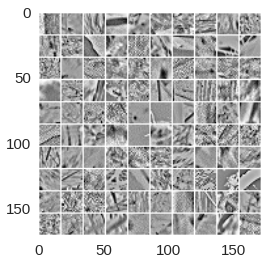

In [38]:
I = grid2d(S[:100])
plt.imshow(I)

In [39]:
from keras.callbacks import Callback
class Renorm(Callback):
    def __init__(self, W):
        self.W = W
    def on_batch_begin(self, batch, logs={}):
        W = self.W.get_value()
        norm = np.sqrt((W**2).sum(axis=1))
        W = W / norm[:, None]
        self.W.set_value(W)
        
        
class FistaCBK(Callback):
    def __init__(self, layer):
        self.layer = layer
    def on_batch_begin(self, batch, logs={}):
        s = batch * 100
        l = (batch + 1) * 100
        X = S[s:l]
        self.layer._fista.y.set_value(self.layer.X.get_value())
        self.layer._fista.optimize(X)
        #X = S[s:l].T
        #self.layer._fista(X, invL=.001)
    def on_epoch_end(self, batch, logs={}):
        x = self.layer.X.get_value() * 0
        self.layer.X.set_value(x)
        self.layer._fista.y.set_value(x)

def new_mse(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

In [40]:
model = Sequential()
model.add(
    SparseCoding(
        input_dim=256,
        output_dim=256,
        n_steps=100,
        gamma=.1,
        truncate_gradient=1, # no backpropagation through time today now,
                             # just regular sparse coding
        # W_regularizer=l2(.00005),
        return_reconstruction=True # we will output Ax which approximates the input
    )
)

sgd = SGD(.1)
model.compile(loss=sum_mse, optimizer=sgd) # RMSprop for Maximization as well

renorm = RenormalizeWeight(model.layers[0].W, transpose=True)

In [41]:
import warnings
warnings.filterwarnings("ignore")

nb_epoch = 10
batch_size = 100
model.fit(S, # input 
          S, # and output are the same thing, since we are doing generative modeling.
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          show_accuracy=False,
          verbose=1, shuffle=False,
          callbacks=[renorm])

Epoch 1/10
50000/50000 [==============================] - 9s - loss: 2904.6800     
Epoch 2/10
50000/50000 [==============================] - 9s - loss: 2901.9947     
Epoch 3/10
50000/50000 [==============================] - 9s - loss: 2901.9003     
Epoch 4/10
50000/50000 [==============================] - 9s - loss: 2902.2895     
Epoch 5/10
50000/50000 [==============================] - 9s - loss: 2902.0994     
Epoch 6/10
50000/50000 [==============================] - 9s - loss: 2902.0665     
Epoch 7/10
50000/50000 [==============================] - 9s - loss: 2902.0642     
Epoch 8/10
50000/50000 [==============================] - 9s - loss: 2902.0008     
Epoch 9/10
50000/50000 [==============================] - 9s - loss: 2901.9024     
Epoch 10/10
50000/50000 [==============================] - 9s - loss: 2902.0022     


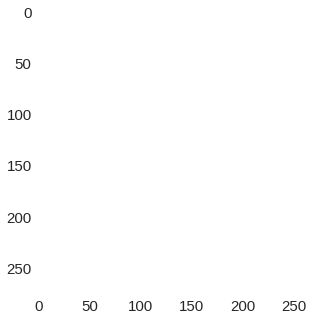

In [42]:
# Visualizing results
A = model.params[0].get_value()
I = grid2d(A)
plt.figure(figsize=(5, 5))
plt.imshow(I)

In [18]:
A.max()

0.59882444

#Sparse2L

In [4]:
class Vchange(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        self.V = model.nodes['sc'].params[1].get_value()
        self.W = model.nodes['sc'].params[0].get_value()
    def on_epoch_end(self, epoch, logs={}):
        V = model.nodes['sc'].params[1].get_value()
        print abs(V-self.V).sum()
        W = model.nodes['sc'].params[0].get_value()
        print abs(W-self.W).sum()

In [5]:
def self_cost(y_true, y_pred):
    return y_pred.sum() + y_true.sum()*0

In [6]:
model = Graph()
model.add_input(name='input', ndim=2)
model.add_node(Sparse2L(input_dim=256, output_dim=256*4, return_mode='all', truncate_gradient=1,
                        causes_dim=9, n_steps=100, gamma=.3), name='sc', input='input')
model.add_node(Lambda(lambda x: x[2]), name='causes', input='sc', create_output=True)
model.add_node(Lambda(lambda x: x[3]), name='rec', input='sc', create_output=True)

In [7]:
model.nodes['sc'].get_output()
vchange = Vchange()

In [8]:
renorm_W = RenormalizeWeight(model.nodes['sc'].params[0])
renorm_V = RenormalizeWeight(model.nodes['sc'].params[1], transpose=True)
rms = SGD(lr=.1)
model.compile(loss={'causes': self_cost, 'rec': sum_mse}, optimizer=rms)

/home/eders/python/Theano/theano/scan_module/scan_perform_ext.py:134: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [9]:
batch_size = 100
nb_epoch = 10
model.fit({'input': S,'causes':np.zeros((60000,1)), 'rec': S},
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          verbose=1,
          callbacks=[renorm_W, renorm_V, vchange])

Epoch 0
50000/50000 [==============================] - 41s - loss: 72.8919    
2219.98
9513.34
Epoch 1
50000/50000 [==============================] - 41s - loss: 66.8139    
0.040484
3848.64
Epoch 2
50000/50000 [==============================] - 41s - loss: 65.6094    
0.0336543
2448.0
Epoch 3
50000/50000 [==============================] - 41s - loss: 65.0537    
0.0301128
1808.19
Epoch 4
50000/50000 [==============================] - 41s - loss: 64.7287    
0.0284246
1474.1
Epoch 5
50000/50000 [==============================] - 41s - loss: 64.5204    
0.0274924
1288.65
Epoch 6
50000/50000 [==============================] - 41s - loss: 64.3696    
0.0269599
1165.29
Epoch 7
50000/50000 [==============================] - 41s - loss: 64.2587    
0.0267363
1088.39
Epoch 8
50000/50000 [==============================] - 41s - loss: 64.1740    
0.0266572
1027.73
Epoch 9
50000/50000 [==============================] - 41s - loss: 64.1080    
0.0265997
996.352


In [15]:
def pref_grid2(above, bellow, num_preferred=9, abs_value=True, pad_row=5):
      idx = np.random.randint(above.shape[0], size=num_preferred)
      R = np.abs(above) if abs_value else above
      X = np.zeros((num_preferred**2, bellow.shape[1]))
      print R.shape
      fig = plt.figure(figsize=(10,10))
      c = 0
      for i, w in enumerate(R):
          s = np.argsort(w)[::-1]
          # prefs = s[:-num_preferred-1:-1]
          prefs = s[:num_preferred]
          first = i*num_preferred
          last = (i+1)*num_preferred
          X[first:last] = bellow[prefs]
          for j in range(num_preferred):
                c += 1
                plt.subplot(R.shape[0], num_preferred, c)
                plt.imshow(bellow[prefs][j].reshape(16,16))
                plt.axis('off')
      # visual = grid2d(X, pad_col=1, pad_row=pad_row)
      return fig  # visual[pad_row-1:-pad_row+1, :]

In [18]:
W = model.nodes['sc'].W.get_value()
V = model.nodes['sc'].V.get_value() # .reshape((100, 1, 8, 8)).repeat(2, axis=1).repeat(2, axis=2).reshape((100, -1))
# print V.shape
I = grid2d(W)
J = pref_grid(V[:9], W, num_preferred=9, abs_value=False)
H = grid2d(V)

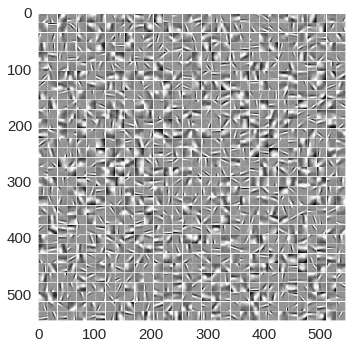

In [19]:
plt.imshow(I)

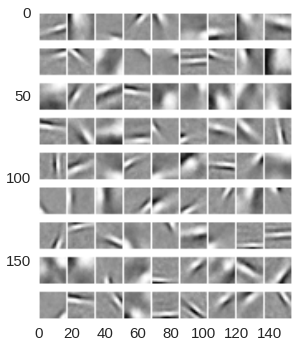

In [20]:
plt.imshow(J)

In [21]:
V.min()

3.047581e-06

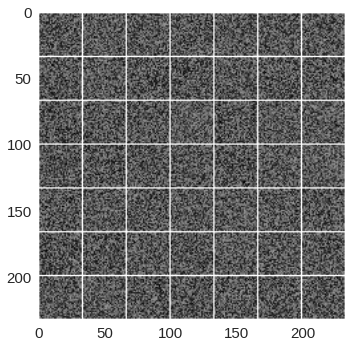

In [22]:
plt.imshow(H)

In [23]:
W.shape

(1024, 256)

In [24]:
V.shape

(49, 1024)